# Определение возраста покупателей

## Исследовательский анализ данных

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [10]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Посмотрим на размер выборки, изучим информацию.

In [11]:
labels.shape

(7591, 2)

In [12]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Датасет в порядке. 

Построим график распределения возраста в выборке.

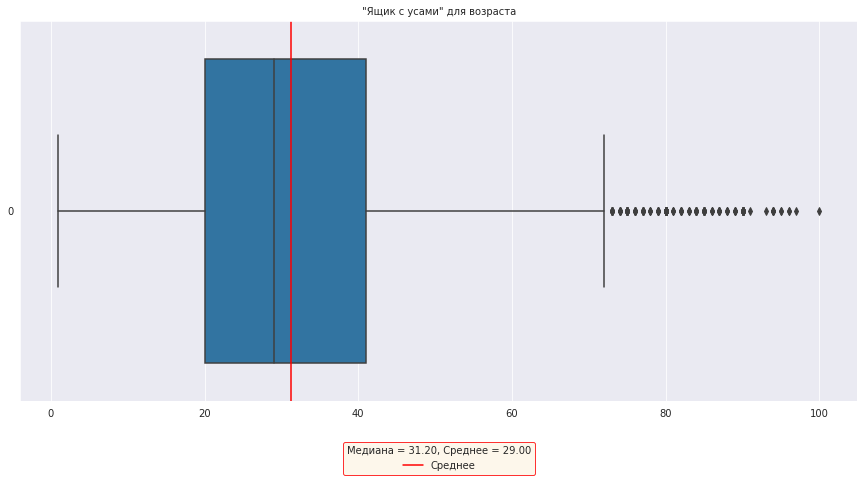

In [13]:
plt.figure(figsize=[15, 7])
plt.title(f'"Ящик с усами" для возраста', fontsize=10)
sns.set_style('darkgrid')
sns.boxplot(data=labels['real_age'], orient='h')
plt.axvline(np.mean(labels['real_age']), 
            color='r', 
            linestyle='-',
            label='Среднее')
median = np.mean(labels['real_age'])
mean = np.median(labels['real_age'])
plt.legend(title=f'Медиана = {median:.2f}, Среднее = {mean:.2f}', 
           loc='center', 
           edgecolor = 'r',
           facecolor = 'oldlace',
           bbox_to_anchor=(0.5, -0.15));

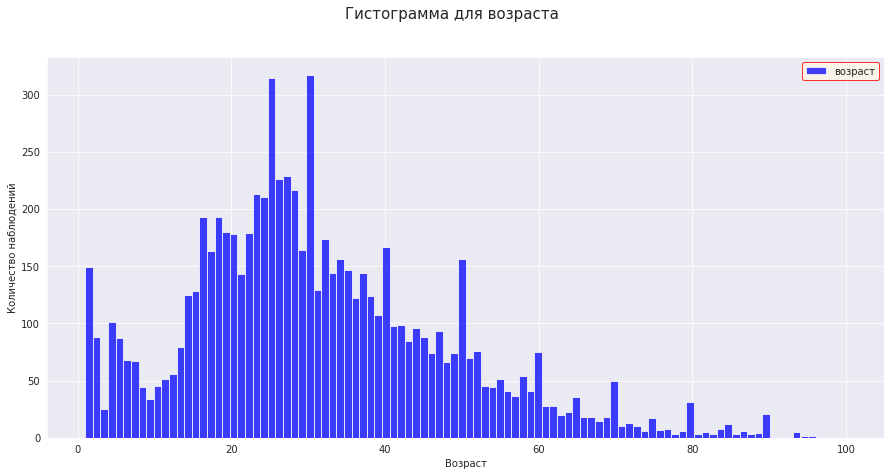

In [14]:
plt.figure(figsize=[15, 7])
plt.suptitle('Гистограмма для возраста', fontsize=15)
sns.set_style('darkgrid')
sns.histplot(data=labels['real_age'], color='b', label='возраст',bins=100, kde=False)
plt.xlabel('Возраст')
plt.ylabel('Количество наблюдений')
plt.grid(True)
plt.legend(edgecolor = 'r', facecolor = 'oldlace')
plt.show();

Как видим на гистограмме, большое количество фотографий принадлежит диапазону возрастов от 15 лет до 50 лет. Значительно меньше фотографий принадлежат диапазону возрастов от 0 до 15 лет и от 50+ и до 70. После отметки 70 наблюдаются выбросы. Возможно это может негативно отражаться на качестве обучения модели.

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [16]:
features, target = next(train_gen_flow)

In [17]:
print(features.shape)

(32, 224, 224, 3)


Выведем на экран 15 фотографий и изучим.

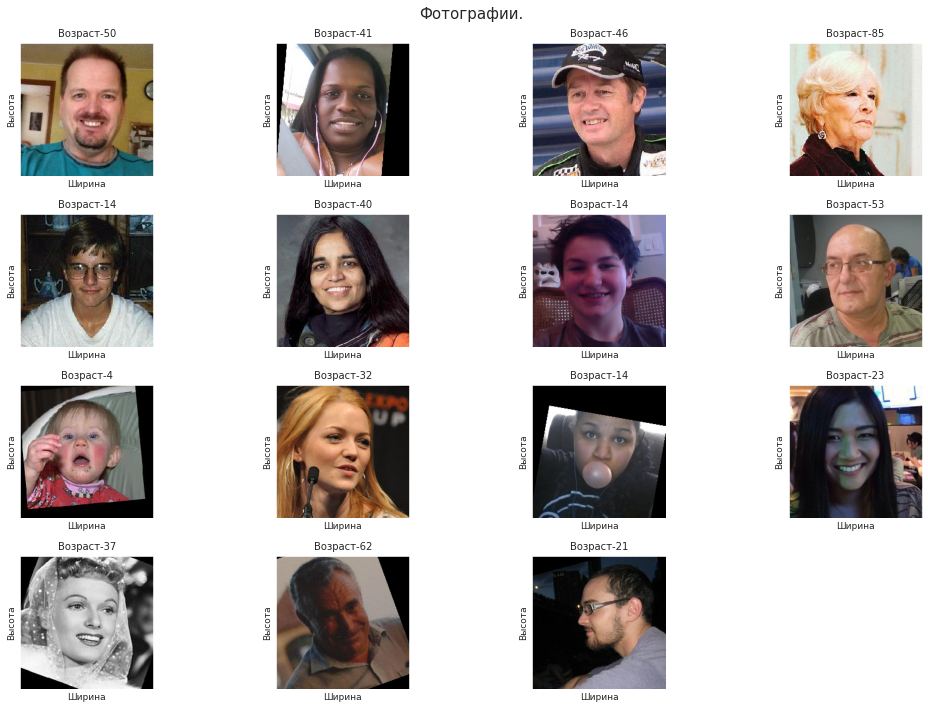

In [22]:
fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.90, wspace=0.3, hspace=0.95)
for i in range(15):
    plt.suptitle('Фотографии.', fontsize=15)
    fig.add_subplot(4,4, i+1)
    plt.title(f'Возраст-{target[i]}', fontsize=10)
    plt.imshow(features[i])
    plt.grid(False)
    plt.ylabel('Высота', fontsize=9)
    plt.xlabel('Ширина', fontsize=9)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

### Вывод

В наборе данных обнаружено неравномерное количество фотографий для разных категорий возрастов. 

Так, небольшое количество фотографий может негавтино отразится в будущем на качестве обучения модели.

Фотографии:

- В наборе присутствуют как цветные, так и черно-белые фото.

- Ориентация стандартная (дополнительных действий не потребовалось).

- Все фото приведеные к одному масштабу.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.25,
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                      directory=path+'/final_files',    
                                                      x_col='file_name',
                                                      y_col='real_age',
                                                      target_size=(224,224),
                                                      batch_size=32,
                                                      class_mode='raw',
                                                      subset='training',  
                                                      seed = 12345)
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255.,
                                      validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                         directory=path+'/final_files',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224,224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',     
                                                         seed = 12345)
    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet',
                        include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-06-21 21:56:53.677364: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-21 21:56:54.167779: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 110s - loss: 294.5100 - mae: 12.5205 - val_loss: 698.6328 - val_mae: 21.4812
Epoch 2/10
178/178 - 89s - loss: 118.1622 - mae: 8.1958 - val_loss: 481.2846 - val_mae: 16.6792
Epoch 3/10
178/178 - 88s - loss: 100.8308 - mae: 7.5871 - val_loss: 314.4513 - val_mae: 13.1839
Epoch 4/10
178/178 - 88s - loss: 84.3772 - mae: 6.9776 - val_loss: 125.3787 - val_mae: 8.5667
Epoch 5/10
178/178 - 88s - loss: 72.5015 - mae: 6.5023 - val_loss: 96.3381 - val_mae: 7.3782
Epoch 6/10
178/178 - 88s - loss: 67.4346 - mae: 6.2673 - val_loss: 80.5660 - val_mae: 6.9621
Epoch 7/10
178/178 - 88s - loss: 61.1549 - mae: 5.9710 - val_loss: 127.3368 - val_mae: 8.4170
Epoch 8/10
178/178 - 88s - loss: 57.8611 - mae: 5.8449 - val_loss: 100.4298 - val_mae: 7.3453
Epoch 9/10
178/178 - 88s - loss: 51.3704 - mae: 5.4883 - val_loss: 76.0843 - val_mae: 6.4214
Epoch 10/10
178/178 - 88s - loss: 46.3594 - mae: 5.2377 - val_loss: 81.1847 - val_mae: 6.6691
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 81.1847 - mae: 6.6691
Test MAE: 6.6691

```

### Вывод

Модель обучена, достигнут результат отметки MAE ниже 8.

## Анализ обученной модели

Для получения наилучшего качества модели использована аугментациа данных, а так же алгоритм Adam с частотой обучения lr = 0.0001 и архитектуру RestNet50, с количеством эпох 10.

### Вывод

При обучение модели получена отметка MAE ниже 8. 

Для достижения наилучшего качества модели использовались:

- aугментация данных

Горизонтальное отражение фотографий и сдвиг по ширине/высоте (добавлние фотографий, неотличимых от настоящих) позволит увеличить выборку, поможет увеличить качество обучения модели.

- алгоритм Adam с частотой обучения lr = 0.0001 

Чем ниже скорость обучения (шаг градиентного спуска), тем лучше подбираются параметры для нейронов.

- архитектура RestNet50

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы